In [1]:
import sys
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import make_column_transformer

sys.path.append("/Users/nwong/Workspace/Projects/tdt4173_project/src")

from feature_engineering.sklearn_transformers import *
from feature_engineering.store_features import *
from feature_engineering.bus_stop_features import *
from feature_engineering.utils import *
import h2o
from h2o.automl import H2OAutoML

stop_importance_levels = ['Mangler viktighetsnivå',
                          'Standard holdeplass',
                          'Lokalt knutepunkt',
                          'Nasjonalt knutepunkt',
                          'Regionalt knutepunkt',
                          'Annen viktig holdeplass']
store_types = ['lv1_desc', 'lv2_desc', 'lv3_desc', 'lv4_desc']
geo_groups = ['grunnkrets_id','t_district','municipality_name']

In [2]:
stores_train_df = set_year_2016(pd.read_csv("/Users/nwong/Workspace/Projects/tdt4173_project/data/raw/stores_train.csv"))
stores_test_df = set_year_2016(pd.read_csv("/Users/nwong/Workspace/Projects/tdt4173_project/data/raw/stores_test.csv"))
stores_extra_df = set_year_2016(pd.read_csv("/Users/nwong/Workspace/Projects/tdt4173_project/data/raw/stores_extra.csv"))

income_dist = set_year_2016(pd.read_csv("/Users/nwong/Workspace/Projects/tdt4173_project/data/raw/grunnkrets_income_households.csv"))
age_dist = set_year_2016(pd.read_csv("/Users/nwong/Workspace/Projects/tdt4173_project/data/raw/grunnkrets_age_distribution.csv"))
household_dist = set_year_2016(pd.read_csv("/Users/nwong/Workspace/Projects/tdt4173_project/data/raw/grunnkrets_households_num_persons.csv"))
grunnkrets_df = combine_keys(set_year_2016(pd.read_csv("/Users/nwong/Workspace/Projects/tdt4173_project/data/raw/grunnkrets_norway_stripped.csv")))
plaace_df = pd.read_csv("/Users/nwong/Workspace/Projects/tdt4173_project/data/raw/plaace_hierarchy.csv")

bus_stops_df = bus_stops_lat_lon(pd.read_csv("/Users/nwong/Workspace/Projects/tdt4173_project/data/raw/busstops_norway.csv"))


/Users/nwong/Workspace/Projects/tdt4173_project/src/feature_engineering/bus_stop_features.py:11: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  bus_stops_df[['lon', 'lat']] = bus_stops_df['lng_lat'].str.split(


In [6]:
stores_train_df

,store_id,store_name,plaace_hierarchy_id,sales_channel_name,grunnkrets_id,address,lat,lon,chain_name,mall_name,revenue
0,983540538-974187930-44774,MCDONALD'S BRAGERNES TORG MAGASINET,1.1.1.0,Hamburger restaurants,6020303,BRAGERNES TORG 13,59.743104,10.204928,MCDONALDS,Magasinet Drammen,17.998
1,987074191-973117734-44755,MCDONALD'S KLINGENBERGGATA,1.1.1.0,Hamburger restaurants,3010306,NaN,59.913759,10.734031,MCDONALDS,NaN,23.828
2,984890265-981157303-64491,BURGER KING HØNEFOSS,1.1.1.0,Hamburger restaurants,6050102,KONG RINGS GATE 1,60.164751,10.254656,BURGER KING,Kuben Hønefoss,16.099
3,914057442-992924179-126912,BURGER KING GLASSHUSPASSASJEN,1.1.1.0,Hamburger restaurants,18040102,STORGATA 12,67.283669,14.379796,BURGER KING,Glasshuspassasjen,9.296
4,913018583-913063538-668469,BURGER KING TILLERTORGET,1.1.1.0,Hamburger restaurants,16017414,NaN,63.358068,10.374832,BURGER KING,Tillertorget,4.528
...,...,...,...,...,...,...,...,...,...,...,...
12854,915789943-915806929-781991,MEIERIGÅRDEN BRYGGERIUTSALG,2.8.11.2,Beer and soda shop,7010705,THUEGATA 2,59.416276,10.480970,NaN,NaN,0.088
12855,917921733-917982368-868081,GULATING ØLUTSALG CC GJØVIK,2.8.11.2,Beer and soda shop,5020406,NaN,60.799991,10.693635,GULATING GRUPPEN,CC Gjøvik,1.816
12856,911721961-911764474-496764,GULATING ØLUTSALG STRØMMEN,2.8.11.2,Beer and soda shop,2310803,STØPERIVEIEN 6,59.946562,11.007659,GULATING GRUPPEN,Strømmen Storsenter,38.225
12857,914337046-914343372-721294,DET GODE BRYGG,2.8.11.2,Beer and soda shop,11020113,VÅGSGATA 16,58.850261,5.735674,NaN,Bystasjonen,3.642


In [29]:
cluster_simil = ClusterSimilarity(n_clusters=100, gamma=1., random_state=42, sample_weight=stores_train_df[['revenue']])
similarities = cluster_simil.fit(stores_train_df[["lat", "lon"]])

def new_clustering(cluster_simil, stores_df):
    return pd.DataFrame(cluster_simil.transform(stores_df[['lat', 'lon']]), columns=cluster_simil.get_feature_names_out(), index=stores_df.store_id).reset_index()

In [30]:
new_clustering(cluster_simil, stores_test_df)

,store_id,Cluster 0 similarity,Cluster 1 similarity,Cluster 2 similarity,Cluster 3 similarity,Cluster 4 similarity,Cluster 5 similarity,Cluster 6 similarity,Cluster 7 similarity,Cluster 8 similarity,...,Cluster 90 similarity,Cluster 91 similarity,Cluster 92 similarity,Cluster 93 similarity,Cluster 94 similarity,Cluster 95 similarity,Cluster 96 similarity,Cluster 97 similarity,Cluster 98 similarity,Cluster 99 similarity
0,914206820-914239427-717245,9.986898e-01,1.203728e-51,8.528569e-14,2.861952e-123,4.308677e-06,4.111865e-30,2.300314e-05,8.064720e-202,6.938671e-10,...,1.518346e-29,2.592709e-04,0.000039,3.226709e-37,7.372870e-01,2.342372e-08,7.967020e-01,2.412727e-07,3.276413e-203,7.415175e-14
1,916789157-916823770-824309,1.569114e-01,1.173893e-64,3.079385e-09,3.758404e-144,1.137556e-08,2.812064e-39,2.954433e-02,1.162206e-228,1.036163e-08,...,2.227169e-37,1.541227e-07,0.001271,3.634054e-47,6.076711e-02,3.661041e-11,3.070076e-02,3.639519e-11,4.166960e-230,1.083094e-08
2,913341082-977479363-2948,9.675334e-01,1.826276e-50,1.953482e-14,3.071394e-121,5.498771e-06,2.411059e-29,8.720111e-06,4.281315e-199,3.408204e-10,...,6.091586e-29,4.078738e-04,0.000019,2.207737e-36,7.837892e-01,3.060784e-08,8.926356e-01,4.189942e-07,1.815059e-200,1.526556e-14
3,889682582-889697172-28720,4.048395e-06,7.617949e-33,3.336724e-16,1.710116e-99,9.952279e-01,4.761231e-14,3.214493e-15,4.139401e-181,1.314565e-05,...,1.697755e-11,2.389753e-01,0.000004,2.623947e-18,2.001716e-07,6.263411e-01,1.832113e-05,3.863818e-01,3.673961e-184,3.224444e-19
4,997991699-998006945-417222,9.986759e-01,1.451330e-51,8.810288e-14,3.559659e-123,4.705826e-06,4.870280e-30,2.227340e-05,9.695278e-202,7.548020e-10,...,1.832074e-29,2.772560e-04,0.000041,3.910419e-37,7.297384e-01,2.602332e-08,8.010948e-01,2.649327e-07,3.883835e-203,7.478044e-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8572,917323003-917383529-844309,1.084616e-13,4.097205e-101,2.827705e-01,1.185181e-203,2.458252e-19,1.093770e-64,2.417502e-04,2.343550e-310,1.697360e-07,...,6.289565e-57,4.746867e-22,0.000065,3.088664e-73,7.320727e-16,3.671430e-21,6.241498e-16,1.970057e-25,3.876233e-313,9.762013e-01
8573,917353379-917411824-845904,4.338239e-12,2.546099e-99,1.176541e-01,2.969968e-200,1.024698e-18,1.231868e-63,2.916412e-03,8.667033e-305,8.032656e-08,...,1.528779e-56,6.610835e-21,0.000132,2.361358e-72,5.155352e-14,9.192464e-21,2.954593e-14,1.446547e-24,2.534784e-307,6.974456e-01
8574,917072302-917089248-833647,8.432995e-01,2.164802e-49,1.235100e-15,6.206712e-119,3.192624e-06,7.390658e-29,2.303396e-06,1.555302e-195,4.452163e-11,...,8.504066e-29,4.056154e-04,0.000004,6.952925e-36,8.750950e-01,1.566223e-08,9.314480e-01,3.784579e-07,8.081977e-197,1.025162e-15
8575,916960557-916993161-829908,2.030712e-14,5.522053e-94,9.708386e-01,3.886910e-195,2.053485e-16,2.426470e-58,1.894832e-06,3.702826e-303,8.632369e-05,...,7.747543e-50,5.490461e-20,0.000529,6.140871e-66,5.227081e-17,1.554948e-17,2.007348e-16,2.847027e-22,1.620154e-306,3.373038e-01


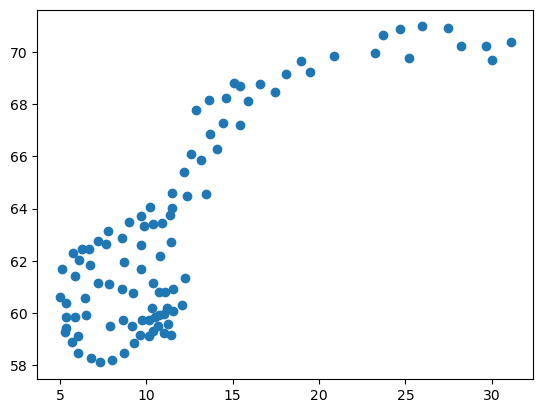

In [24]:
from matplotlib import pyplot as plt
df = pd.DataFrame(cluster_simil.kmeans_.cluster_centers_)
plt.scatter(df[1], df[0])